# 空间数据操作

## 准备

In [2]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 6)
pd.options.display.max_colwidth = 35
plt.rcParams["figure.figsize"] = (5, 5)

In [3]:
import shapely.geometry
import geopandas as gpd
import numpy as np
import os
import rasterio
import scipy.ndimage
import rasterio.merge

from rasterio.plot import show

读取数据：

In [4]:
#| echo: false
from pathlib import Path
data_path = Path("data")
file_path = Path("data/landsat.tif")
if not file_path.exists():
  if not data_path.is_dir():
     os.mkdir(data_path)
  print("Attempting to get the data")
  import requests
  r = requests.get("https://github.com/geocompx/geocompy/releases/download/0.1/landsat.tif")  
  with open(file_path, "wb") as f:
    f.write(r.content)

In [5]:
nz = gpd.read_file("data/nz.gpkg")
nz_height = gpd.read_file("data/nz_height.gpkg")
world = gpd.read_file('data/world.gpkg')
cycle_hire = gpd.read_file('data/cycle_hire.gpkg')
cycle_hire_osm = gpd.read_file('data/cycle_hire_osm.gpkg')``
src_elev = rasterio.open("data/elev.tif")
src_multi_rast = rasterio.open("data/landsat.tif")
src_grain = rasterio.open('data/grain.tif')

## 简介

## 矢量数据的空间操作 

### 空间子集化

空间子集化是获取空间对象并返回仅包含与另一个对象在空间中相关的特征的新对象的过程。
类似于属性子集（在 @sec-vector-attribute-subsetting 中介绍），可以使用方括号（“[”）运算符使用语法“x[y]”创建“GeoDataFrame”的子集，其中“x”是 一个“GeoDataFrame”，将从中返回行/特征的子集，“y”是“子集对象”。
反过来，可以使用一种二元几何关系方法创建“y”，例如“.intersects”（请参阅@sec-topological-relations）。

为了演示空间子集化，我们将使用投影坐标系中的“nz”和“nz_height”图层，它们分别包含新西兰 16 个主要地区和 101 个最高点的地理数据 (@fig-spatial-subset) .
以下代码行创建一个表示坎特伯雷 (`canterbury`) 的对象，然后使用空间子集返回该区域中的所有高点 (`canterbury_height`)：

In [6]:
canterbury = nz[nz['Name'] == 'Canterbury']
canterbury

,Name,Island,Land_area,...,Median_income,Sex_ratio,geometry
10,Canterbury,South,44504.499091,...,30100,0.975327,MULTIPOLYGON (((1686901.914 535...


In [7]:
# Does each 'nz_height' point intersect with 'canterbury'?
sel = nz_height.intersects(canterbury['geometry'].iloc[0])
sel

0      False
1      False
       ...  
99     False
100    False
Length: 101, dtype: bool

In [8]:
canterbury_height = nz_height[sel]
canterbury_height

,t50_fid,elevation,geometry
4,2362630,2749,POINT (1378169.600 5158491.453)
5,2362814,2822,POINT (1389460.041 5168749.086)
...,...,...,...
93,2380300,2711,POINT (1654213.379 5349962.973)
94,2380308,2885,POINT (1654898.622 5350462.779)


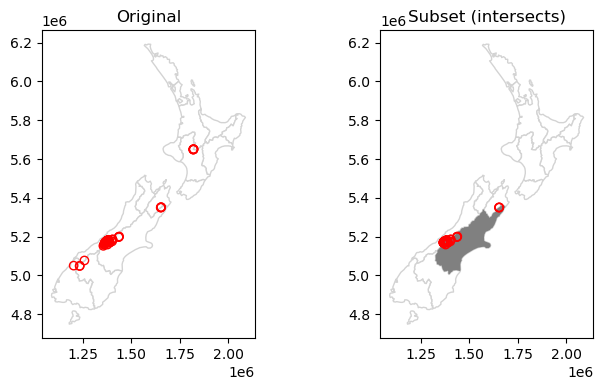

In [9]:
#| label: fig-spatial-subset
#| fig-cap: Spatial subsetting of points by intersection with polygon

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[0])
nz_height.plot(ax=base, color='None', edgecolor='red')
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[1])
canterbury.plot(ax=base, color='grey', edgecolor='none')
canterbury_height.plot(ax=base, color='None', edgecolor='red')
axes[0].set_title('Original')
axes[1].set_title('Subset (intersects)');

与属性子集 (@sec-vector-attribute-subsetting) 一样，我们使用布尔系列 (`sel`)，其长度与过滤表 (`nz_height`) 中的行数相同，基于 条件应用于自身。
不同的是，条件不是属性值的比较，而是空间关系的评估。
也就是说，我们使用“.intersects”方法评估“nz_height”的每个几何图形是否与“canterbury”几何图形相交。

各种拓扑关系可用于空间子集化，确定目标对象中的要素与要选择的子集化对象必须具有的空间关系类型。
这些包括接触、交叉或内部，我们很快就会在@sec-topological-relations 中看到。
我们在上一个示例中使用的最常用的方法 .intersects 方法是“捕获所有”拓扑关系，它将返回目标中接触、交叉或位于源“子集”对象内的特征。
或者，我们可以评估其他方法，例如“.disjoint”来获取所有“不”与坎特伯雷相交的点：

In [10]:
# Is each 'nz_height' point disjoint from 'canterbury'?
sel = nz_height.disjoint(canterbury['geometry'].iloc[0])
canterbury_height2 = nz_height[sel]

如@fig-spatial-subset-disjoint 所示：

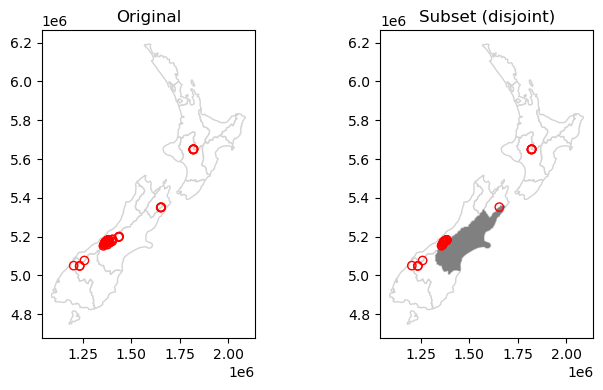

In [11]:
#| label: fig-spatial-subset-disjoint
#| fig-cap: Spatial subsetting of points disjoint from a polygon

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[0])
nz_height.plot(ax=base, color='None', edgecolor='red')
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[1])
canterbury.plot(ax=base, color='grey', edgecolor='none')
canterbury_height2.plot(ax=base, color='None', edgecolor='red');
axes[0].set_title('Original')
axes[1].set_title('Subset (disjoint)');

如果我们需要同时根据多个几何图形进行子集化，例如找出哪些点与坎特伯雷和南地相交，我们可以在应用“.intersects”（或任何其他）运算符之前溶解过滤子集：

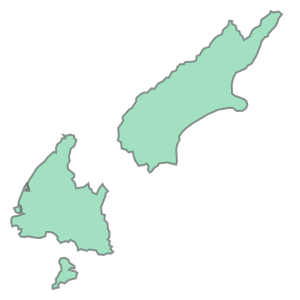

In [12]:
canterbury_southland = nz[(nz['Name'] == 'Canterbury') | (nz['Name'] == 'Southland')]
canterbury_southland = canterbury_southland.unary_union
canterbury_southland

In [13]:
sel = nz_height.intersects(canterbury_southland)
canterbury_southland_height = nz_height[sel]
canterbury_southland_height

,t50_fid,elevation,geometry
0,2353944,2723,POINT (1204142.603 5049971.287)
4,2362630,2749,POINT (1378169.600 5158491.453)
...,...,...,...
93,2380300,2711,POINT (1654213.379 5349962.973)
94,2380308,2885,POINT (1654898.622 5350462.779)


生成的子集显示在 @fig-spatial-subset2 中：

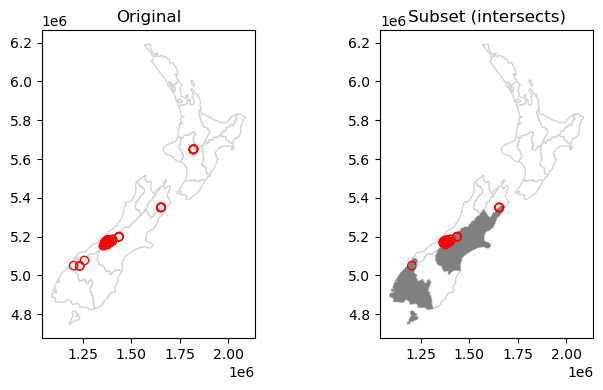

In [14]:
#| label: fig-spatial-subset2
#| fig-cap: Spatial subsetting of points by intersection with more that one polygon

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[0])
nz_height.plot(ax=base, color='None', edgecolor='red')
base = nz.plot(color='white', edgecolor='lightgrey', ax=axes[1])
gpd.GeoSeries(canterbury_southland).plot(ax=base, color='grey', edgecolor='none')
canterbury_southland_height.plot(ax=base, color='None', edgecolor='red')
axes[0].set_title('Original')
axes[1].set_title('Subset (intersects)');

下一节将进一步探讨不同类型的空间关系，也称为二元谓词（其中“.intersects”和“.disjoint”是两个示例），可用于识别两个要素是否在空间上相关。

### 拓扑关系 {#sec-topological-relations}

拓扑关系描述了对象之间的空间关系。 “二元拓扑关系”，全称为“二元拓扑关系”，是关于由有序点集（通常形成点、 线和多边形）在两个或多个维度（Egenhofer 和 Herring 1990）。 这听起来可能相当抽象，事实上，拓扑关系的定义和分类是基于 1966 年首次以书籍形式出版的数学基础（Spanier 1995），代数拓扑领域一直延续到 21 世纪（Dieck 2008）。

尽管拓扑关系起源于数学，但可以参考测试常见类型空间关系的常用函数的可视化来直观地理解拓扑关系。 图 4.2 显示了各种几何对及其关联关系。 图 4.2 中的第三对和第四对（从左到右，然后向下）表明，对于某些关系，顺序很重要：而相等、相交、交叉、接触和重叠的关系是对称的，这意味着如果 function(x, y) 为 true，则 function(y, x) 也为 true，其中几何顺序很重要的关系（例如 contains 和 inside 不重要）。 请注意，每个几何对都有一个“DE-9IM”字符串，例如 FF2F11212，如下一节所述。

![矢量几何之间的拓扑关系，受到 Egenhofer 和 Herring (1990) 中图 1 和图 2 的启发。 为每个几何对打印函数 (x, y) 为真的关系，其中 x 用粉色表示，y 用蓝色表示。 每对空间关系的性质由维度扩展 9 相交模型字符串描述。 ](https://geocompr.robinlovelace.net/04-spatial-operations_files/figure-html/relations-1.png)

在`shapely`中，针对不同类型的拓扑关系进行测试的函数被称为[“关系”](https://shapely.readthedocs.io/en/stable/manual.html#relationships)。 为了了解拓扑关系在实践中如何工作，让我们创建一个简单的可重现示例，以图 4.2 中所示的关系为基础，并巩固上一章中关于矢量几何如何表示的知识（@sec-geometry-columns 和 @sec-geometries） :

In [15]:
points = gpd.GeoSeries([
  shapely.geometry.Point(0.2,0.1), 
  shapely.geometry.Point(0.7,0.2), 
  shapely.geometry.Point(0.4,0.8)
])
line = gpd.GeoSeries([
  shapely.geometry.LineString([(0.4,0.2), (1,0.5)])
])
poly = gpd.GeoSeries([
  shapely.geometry.Polygon([(0,0), (0,1), (1,1), (1,0.5), (0,0)])
])

生成的名为“points”、“line”和“poly”的“GeoSeries”可视化如下：

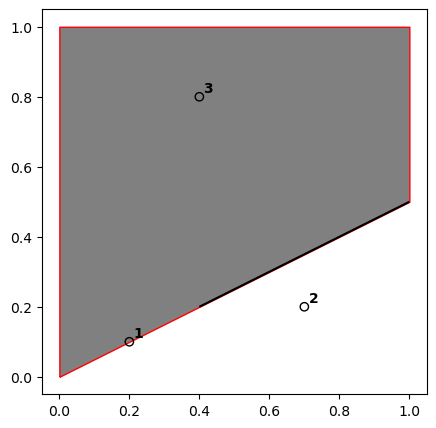

In [16]:
#| label: fig-spatial-relations-geoms
#| fig-cap: Points, line and polygon objects arranged to illustrate topological relations

ax = gpd.GeoSeries(poly).plot(color='grey', edgecolor='red')
ax = gpd.GeoSeries(line).plot(ax=ax, color='black')
points.plot(ax=ax, color='none', edgecolor='black')
for x, y, label in zip(points.x, points.y, [1,2,3]):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), weight='bold', textcoords="offset points")

一个简单的查询是：“points”中的哪些点以某种方式与多边形“poly”相交？ 这个问题可以通过检查来回答（点 1 和点 3 分别接触并在多边形内）。 这个问题可以用`.intersects`方法来回答，如下。 请注意，我们评估“GeoSeries”（“点”）中的每个几何图形与单个“shapely”几何图形（“poly.iloc[0]”）之间的关系。 当两个输入都是“GeoSeries”时，在按索引（“align=True”，默认值）或按位置（“align=False”）对齐的几何图形之间进行成对评估：

In [17]:
points.intersects(poly.iloc[0])

0     True
1    False
2     True
dtype: bool

结果是一个布尔值“Series”。 它的内容应该符合您的直觉：第一个和第三个点返回正（“True”）结果，第二个点返回负结果（“False”）在多边形边界之外。

同样，上面的输出是一个“Series”，其中每个值代表第一个输入（“points”）中的一个特征。 如果我们需要获得*成对*结果的矩阵，我们可以使用“.apply”，如下所示。 在这种情况下，结果是一个“DataFrame”，其中每行代表一个“points”几何图形，每列代表一个“poly”几何图形（在本例中只有一个）L

In [18]:
points.apply(lambda x: poly.intersects(x))

,0
0,True
1,False
2,True


即使在特征刚好接触的情况下，“.intersects”也会返回“True”：intersects 是一种“包罗万象”的拓扑运算，可识别多种类型的空间关系，如图 4.2 所示。 更具限制性的问题包括哪些点位于多边形内，哪些要素位于多边形上或包含与其共享的边界？ 这些可以回答如下：

In [19]:
points.within(poly.iloc[0])

0    False
1    False
2     True
dtype: bool

In [20]:
points.touches(poly.iloc[0])

0     True
1    False
2    False
dtype: bool

请注意，虽然第一个点接触到边界多边形，但它不在其中； 第三个点在多边形内但不接触其边界的任何部分。 `.intersects` 的对立面是 `.disjoint`，它只返回在空间上与选择对象没有任何关系的对象：

In [21]:
points.disjoint(poly.iloc[0])

0    False
1     True
2    False
dtype: bool

另一种有用的关系类型是“在距离内”，我们在其中检测与缓冲特定距离的目标相交的特征。 缓冲距离决定了目标对象在被选中之前需要多近。 这可以通过字面上缓冲（@sec-geometries）目标几何，并评估交集（`.intersects`，见上文）来完成。 另一种方法是计算距离并将它们与距离阈值进行比较：

In [22]:
points.distance(poly.iloc[0]) < 0.2

0    True
1    True
2    True
dtype: bool

请注意，虽然点 2 距离“poly”最近的顶点超过 0.2 个单位的距离，但当距离设置为 0.2 时，它仍然被选中。 这是因为距离是测量到最近的边缘，在本例中是位于图 4.2 中点 2 正上方的多边形部分。 我们可以验证点2到多边形的实际距离是0.13，如下：

In [23]:
points.iloc[1].distance(poly.iloc[0])

0.13416407864998736

### 空间连接

连接两个非空间数据集依赖于共享的“键”变量，如 @sec-vector-attribute-joining 中所述。 空间数据连接应用相同的概念，但依赖于空间关系，如上一节所述。 与属性数据一样，连接将新列从源对象 (y) 添加到目标对象（连接函数中的参数 x）。

下面的例子说明了这个过程：假设你有十个随机分布在地球表面的点，你问，对于陆地上的点，它们位于哪些国家？ 在可重复的示例中实现这个想法将培养您的地理数据处理技能并展示空间连接的工作原理。 起点是创建随机散布在地球表面上的点：

In [24]:
np.random.seed(11)  ## set seed for reproducibility
bb = world.total_bounds  ## the world's bounds
x = np.random.uniform(low=bb[0], high=bb[2], size=10)
y = np.random.uniform(low=bb[1], high=bb[3], size=10)
random_points = gpd.points_from_xy(x, y, crs=4326)
random_points = gpd.GeoSeries(random_points)
random_points = gpd.GeoDataFrame({'geometry': random_points})
random_points

,geometry
0,POINT (-115.10291 36.78178)
1,POINT (-172.98891 -71.02938)
...,...
8,POINT (159.05039 -34.99599)
9,POINT (126.28622 -62.49509)


@fig-spatial-join 中所示的场景显示“random_points”对象（左上）缺少属性数据，而世界（右上）具有属性，包括图例中国家/地区样本显示的国家/地区名称。 空间连接是通过“gpd.sjoin”实现的，如下面的代码块所示。 输出是“random_joined”对象，如@fig-spatial-join（左下）所示。 在创建连接数据集之前，我们使用空间子集创建 world_random，其中仅包含包含随机点的国家/地区，以验证连接数据集中返回的国家/地区名称数量应为 4（请参阅 @fig-spatial- 的右上角面板） 加入）。

In [25]:
# Subset
world_random = world[world.intersects(random_points.unary_union)]
world_random

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
4,US,United States,North America,...,78.841463,51921.984639,MULTIPOLYGON (((-171.73166 63.7...
18,RU,Russian Federation,Europe,...,70.743659,25284.586202,MULTIPOLYGON (((-180.00000 64.9...
52,ML,Mali,Africa,...,57.007000,1865.160622,MULTIPOLYGON (((-11.51394 12.44...
159,AQ,Antarctica,Antarctica,...,NaN,NaN,MULTIPOLYGON (((-180.00000 -89....


In [26]:
# Spatial join
random_joined = gpd.sjoin(random_points, world, how='left')
random_joined

,geometry,index_right,iso_a2,...,pop,lifeExp,gdpPercap
0,POINT (-115.10291 36.78178),4.0,US,...,318622525.0,78.841463,51921.984639
1,POINT (-172.98891 -71.02938),NaN,NaN,...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8,POINT (159.05039 -34.99599),NaN,NaN,...,NaN,NaN,NaN
9,POINT (126.28622 -62.49509),NaN,NaN,...,NaN,NaN,NaN


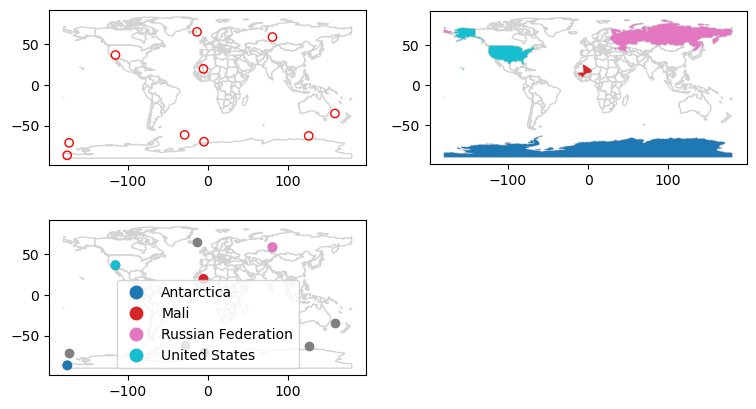

In [27]:
#| label: fig-spatial-join
#| fig-cap: Illustration of a spatial join. A new attribute variable is added to random points (top left) from source world object (top right) resulting in the data represented in the final panel.

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[0][0])
random_points.plot(ax=base, color='None', edgecolor='red')
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[0][1])
world_random.plot(ax=base, column='name_long')
base = world.plot(color='white', edgecolor='lightgrey', ax=axes[1][0])
random_joined.geometry.plot(ax=base, color='grey');
random_joined.plot(ax=base, column='name_long', legend=True)
fig.delaxes(axes[1][1]);

### 非重叠连接

有时，两个地理数据集并不接触，但仍然具有很强的地理关系。
数据集“cycle_hire”和“cycle_hire_osm”提供了一个很好的例子。
对它们进行绘图表明，它们通常密切相关，但并不接触，如 @fig-cycle-hire 所示，它是使用以下代码创建的：

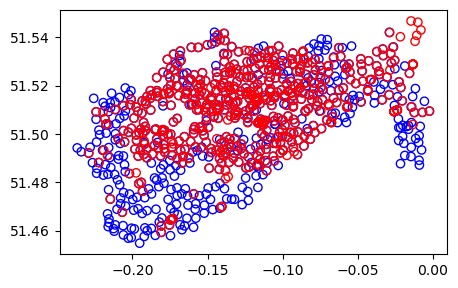

In [28]:
#| label: fig-cycle-hire
#| fig-cap: The spatial distribution of cycle hire points in London based on official data (blue) and OpenStreetMap data (red). 

base = cycle_hire.plot(edgecolor='blue', color='none')
cycle_hire_osm.plot(ax=base, edgecolor='red', color='none');

我们可以通过创建“.intersects”关系的成对布尔矩阵来检查是否有任何点相同，然后评估其中的任何值是否为“True”。
请注意，“.to_numpy”方法应用于从“DataFrame”到“numpy”数组，其中“.any”给出全局而不是逐行摘要，这正是我们在本例中想要的：

In [29]:
m = cycle_hire['geometry'].apply(
  lambda x: cycle_hire_osm['geometry'].intersects(x)
)
m.to_numpy().any()

False

想象一下，我们需要将 cycle_hire_osm 中的容量变量连接到 cycle_hire 中包含的官方“目标”数据。
这是需要非重叠连接的时候。
空间连接 (`gpd.sjoin`) 以及缓冲几何可用于执行此操作。
下面使用 20 m 的阈值距离对此进行了演示。
请注意，我们将数据转换为投影 CRS (`27700`) 以使用以米为单位的实际缓冲距离。

In [30]:
crs = 27700
cycle_hire2 = cycle_hire.copy().to_crs(crs)
cycle_hire2['geometry'] = cycle_hire2.buffer(20)
z = gpd.sjoin(
  cycle_hire2, 
  cycle_hire_osm.to_crs(crs)
)
z[['name_left','name_right']]

,name_left,name_right
0,River Street,River Street
1,Phillimore Gardens,"Kensington, Phillimore Gardens"
...,...,...
729,Ranelagh Gardens,"Ranelagh Gardens, Fulham"
737,Tallis Street,"Tallis Street, Temple"


结果“z”表明目标对象“cycle_hire”在“cycle_hire_osm”阈值距离内有438个点。
请注意，连接结果中的行数大于目标。
这是因为 `cycle_hire` 中的某些自行车租赁站在 `cycle_hire_osm` 中有多个匹配项。
为了聚合重叠点的值并返回平均值，我们可以使用@attr中学到的聚合方法，从而得到一个与目标具有相同行数的对象。
我们还使用“.centroid”从缓冲区返回到点：

In [31]:
z = z[['id', 'capacity', 'geometry']] \
    .dissolve(by='id', aggfunc='mean') \
    .reset_index()
z['geometry'] = z.centroid
z

,id,geometry,capacity
0,1,POINT (531203.517 182832.066),9.0
1,2,POINT (525208.067 179391.922),27.0
...,...,...,...
436,765,POINT (524652.998 175817.001),29.0
437,773,POINT (531435.032 180916.010),14.0


可以通过将源“cycle_hire_osm”数据的容量图与新对象“z”（@fig-cycle-hire-z）中的结果进行比较来验证附近站点的容量：

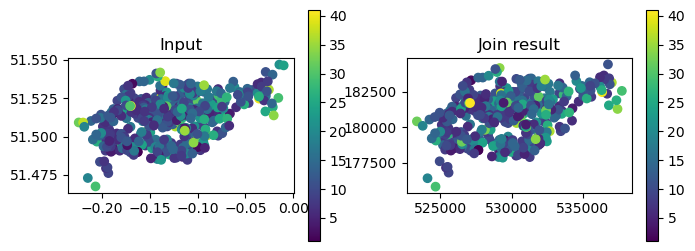

In [32]:
#| label: fig-cycle-hire-z
#| fig-cap: Non-overlapping join input (left) and result (right)

fig, axes = plt.subplots(ncols=2, figsize=(8,3))
cycle_hire_osm.plot(column='capacity', legend=True, ax=axes[0])
z.plot(column='capacity', legend=True, ax=axes[1])
axes[0].set_title('Input')
axes[1].set_title('Join result');

### 空间聚合

与属性数据聚合一样，空间数据聚合会压缩数据：聚合输出的行数少于非聚合输入的行数。
统计聚合函数（例如均值、平均值或总和）汇总一个变量的多个值，并为每个分组变量返回一个值。
@sec-vector-attribute-aggregation 演示了 .groupby 方法如何结合诸如 .sum 之类的汇总函数，基于属性变量压缩数据。
本节展示如何使用空间连接与非空间聚合相结合来实现按空间对象分组。

回到新西兰的例子，假设您想要找出每个地区高点的平均高度。
源 (`nz`) 的几何形状定义了目标对象 (`nz_height`) 中的值如何分组。
这可以通过三个步骤完成：

1. 找出每个 `nz_height` 点落在哪个 `nz` 区域---使用 `gpd.sjoin`
2. 汇总每个区域的平均海拔---使用 .groupby 和 .mean
3. 将结果连接回 `nz` --- 使用 `pd.merge`

首先，我们使用空间连接“附加”每个点的区域分类。
请注意，我们使用的是所需的最小列集：几何图形（用于空间连接）、点高程（稍后计算平均值）和区域名称（在将结果连接回 ` 时用作键 新西兰`）。

In [33]:
nz_height2 = gpd.sjoin(
  nz_height[['elevation', 'geometry']], 
  nz[['Name', 'geometry']], 
  how='left'
)
nz_height2

,elevation,geometry,index_right,Name
0,2723,POINT (1204142.603 5049971.287),12,Southland
1,2820,POINT (1234725.325 5048309.302),11,Otago
...,...,...,...,...
99,2720,POINT (1822262.592 5650428.656),2,Waikato
100,2732,POINT (1822492.184 5650492.304),2,Waikato


其次，我们计算平均海拔：

In [34]:
nz_height3 = nz_height2.groupby('Name')[['elevation']].mean()
nz_height3

,elevation
Name,
Canterbury,2994.600000
Manawatu-Wanganui,2777.000000
...,...
Waikato,2734.333333
West Coast,2889.454545


第三步也是最后一步是将平均值与“nz”层连接起来：

In [35]:
nz_height4 = pd.merge(nz[['Name', 'geometry']], nz_height3, on='Name', how='left')
nz_height4

,Name,geometry,elevation
0,Northland,MULTIPOLYGON (((1745493.196 600...,NaN
1,Auckland,MULTIPOLYGON (((1803822.103 590...,NaN
...,...,...,...
14,Nelson,MULTIPOLYGON (((1624866.279 541...,NaN
15,Marlborough,MULTIPOLYGON (((1686901.914 535...,2720.0


我们现在已经创建了 `nz_height4` 层，它给出了每个多边形的平均 `nz_height` 高程值。 结果显示在@fig-nz-avg-nz-height 中。 请注意，“missing_kwds”部分确定了缺少符号系统属性（“elevation”）的几何样式，因为没有“nz_height”点与它们重叠。 默认是忽略它们，这通常不是我们想要的。 使用`{'color':'none','edgecolor':'black'}`，这些多边形显示为黑色轮廓且无填充。

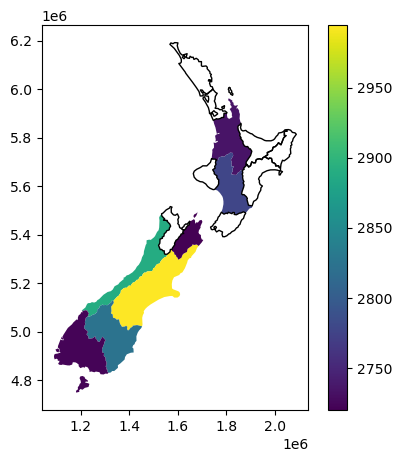

In [36]:
#| label: fig-nz-avg-nz-height
#| fig-cap: Average height of the top 101 high points across the regions of New Zealand

nz_height4.plot(
  column='elevation', 
  legend=True,
  missing_kwds={'color': 'none', 'edgecolor': 'black'}
);

### 连接不一致的层

空间一致性是与空间聚合相关的一个重要概念。 如果两个对象具有共享边界，则聚合对象（我们将其称为“y”）与目标对象（“x”）一致。 行政边界数据通常就是这种情况，较大的单位（例如英国的中层超级输出区 (MSOA) 或许多其他欧洲国家的地区）由许多较小的单位组成。

相比之下，不一致的聚合对象不与目标共享共同边界（Qiu、Zhang 和 Zhou 2012）。 这对于 @fig-nz-and-grid 中所示的空间聚合（和其他空间操作）来说是有问题的：聚合每个子区域的质心将不会返回准确的结果。 面积插值通过将值从一组面积单位转移到另一组面积单位来克服这个问题，使用一系列算法，包括简单的面积加权方法和更复杂的方法，例如“pycnophyctic”方法（Tobler 1979）。

为了演示，我们将创建一个“合成”层，其中包含大小为矩形的[常规网格](https://gis.stackexchange.com/questions/322589/rasterizing-polygon-grid-in-python-geopandas-rasterio) $100\times100$ $km$，覆盖 `nz` 层的范围：

In [37]:
xmin, ymin, xmax, ymax = nz.total_bounds
res = 100000
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax+res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax+res)), res))
rows.reverse()
polygons = []
for x in cols:
    for y in rows:
        polygons.append( shapely.geometry.Polygon([(x,y), (x+res, y), (x+res, y-res), (x, y-res)]) )
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=nz.crs)
sel = grid.intersects(shapely.geometry.box(*nz.total_bounds))
grid = grid[sel]
grid['id'] = grid.index
grid

,geometry,id
0,POLYGON ((1090143.000 6248536.0...,0
1,POLYGON ((1090143.000 6148536.0...,1
...,...,...
157,POLYGON ((1990143.000 4948536.0...,157
158,POLYGON ((1990143.000 4848536.0...,158


如@fig-nz-and-grid 所示。

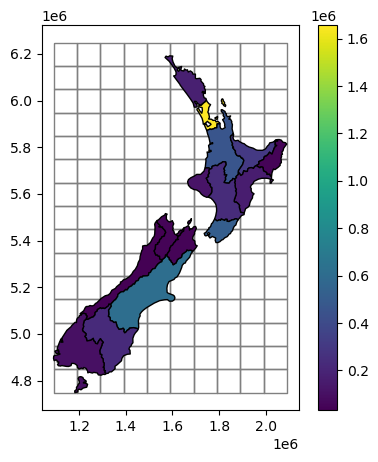

In [38]:
#| label: fig-nz-and-grid
#| fig-cap: The nz layer and a regular grid of rectangles

base = grid.plot(color='none', edgecolor='grey')
nz.plot(ax=base, column='Population', edgecolor='black', legend=True);

现在，我们的目标是将“人口”属性“转移”到矩形网格多边形，这是不一致层之间连接的示例。 为此，我们基本上需要计算每个“网格”单元格与该单元格重合的“nz”多边形中人口的加权总和。 加权和计算中的权重是整个“nz”多边形中重合“部分”的面积之间的比率。 也就是说，我们（不可避免地）假设每个“nz”多边形中的人口在空间上均匀分布，因此部分“nz”多边形包含相应的部分人口规模。

我们首先使用“.area”方法计算每个“nz”多边形的整个面积（参见@sec-area-length）：

In [39]:
nz['area'] = nz.area
nz

,Name,Island,Land_area,...,Sex_ratio,geometry,area
0,Northland,North,12500.561149,...,0.942453,MULTIPOLYGON (((1745493.196 600...,1.289058e+10
1,Auckland,North,4941.572557,...,0.944286,MULTIPOLYGON (((1803822.103 590...,4.911565e+09
...,...,...,...,...,...,...,...
14,Nelson,South,422.195242,...,0.925967,MULTIPOLYGON (((1624866.279 541...,4.080754e+08
15,Marlborough,South,10457.745485,...,0.957792,MULTIPOLYGON (((1686901.914 535...,1.046485e+10


接下来，我们使用 .overlay 方法来计算 nz 和 grid 之间的两两交集，这里命名为 nz_grid 。 我们还计算交叉点的面积，在此命名为“area_sub”。 如果“nz”多边形完全位于单个“grid”多边形内，则“area_sub”将等于“area”； 否则，它会更小：

In [40]:
nz_grid = nz.overlay(grid)
nz_grid = nz_grid[['id', 'area', 'Population', 'geometry']]
nz_grid['area_sub'] = nz_grid.area
nz_grid

,id,area,Population,geometry,area_sub
0,64,1.289058e+10,175500.0,POLYGON ((1590143.000 6162776.6...,3.231015e+08
1,80,1.289058e+10,175500.0,POLYGON ((1600430.924 6148536.0...,4.612641e+08
...,...,...,...,...,...
108,87,4.080754e+08,51400.0,POLYGON ((1643904.326 5448536.0...,1.716260e+07
109,87,1.046485e+10,46200.0,MULTIPOLYGON (((1676051.777 544...,4.526248e+08


我们将在...中详细说明 .overlay 方法。

生成的图层“nz_grid”显示在@fig-nz-and-grid2 中。

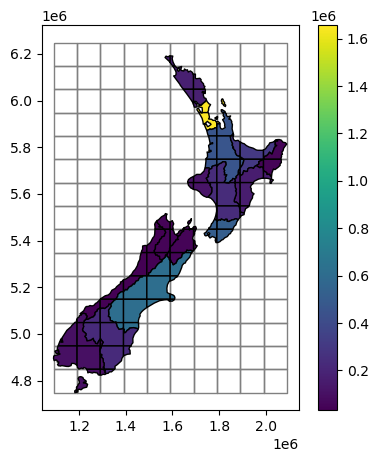

In [41]:
#| label: fig-nz-and-grid2
#| fig-cap: "The nz layer and a regular grid of rectangles: after an overlay operation"

base = grid.plot(color='none', edgecolor='grey')
nz_grid.plot(ax=base, column='Population', edgecolor='black', legend=True);

请注意，每个“交叉点”仍然保留其“nz”“起源”特征的“Population”属性，如 @fig-nz-and-grid2 中所示。 然而，每个“nz_grid”特征的实际人口规模较小（或相等），具体取决于它在原始“nz”特征中所占的地理区域比例。 为了进行“修正”，我们首先计算比率（`area_prop`），然后将其乘以人口。 新的（小写）属性“population”现在可以正确估计“nz_grid”中的人口规模：

In [42]:
nz_grid['area_prop'] = nz_grid['area_sub'] / nz_grid['area']
nz_grid['population'] = nz_grid['Population'] * nz_grid['area_prop']
nz_grid

,id,area,Population,...,area_sub,area_prop,population
0,64,1.289058e+10,175500.0,...,3.231015e+08,0.025065,4398.897141
1,80,1.289058e+10,175500.0,...,4.612641e+08,0.035783,6279.925114
...,...,...,...,...,...,...,...
108,87,4.080754e+08,51400.0,...,1.716260e+07,0.042057,2161.752203
109,87,1.046485e+10,46200.0,...,4.526248e+08,0.043252,1998.239223


剩下要做的是总结（参见@sec-vector-attribute-aggregation）形成相同网格单元的所有部分的人口：

In [43]:
nz_grid = nz_grid.groupby('id')['population'].sum().reset_index()
nz_grid

,id,population
0,11,67.533590
1,12,15339.996965
...,...,...
55,149,31284.910446
56,150,129.326331


并将它们连接回“网格”层（请参阅@sec-vector-attribute-joining）：

In [44]:
grid = pd.merge(grid, nz_grid[['id', 'population']], on='id', how='left')
grid

,geometry,id,population
0,POLYGON ((1090143.000 6248536.0...,0,NaN
1,POLYGON ((1090143.000 6148536.0...,1,NaN
...,...,...,...
148,POLYGON ((1990143.000 4948536.0...,157,NaN
149,POLYGON ((1990143.000 4848536.0...,158,NaN


@fig-nz-and-grid3 中显示了最终结果“grid”以及来自“nz”的不一致连接的“population”属性。

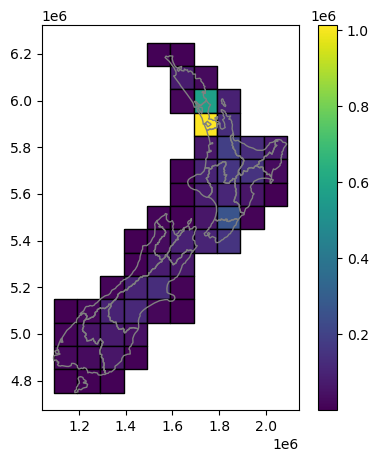

In [45]:
#| label: fig-nz-and-grid3
#| fig-cap: "The nz layer and a regular grid of rectangles: final result"

base = grid.plot(column='population', edgecolor='black', legend=True);
nz.plot(ax=base, color='none', edgecolor='grey', legend=True);

我们可以证明，正如预期的那样，尽管几何形状不同，“nz”和“grid”中的总人口是相同的（因为我们创建了“grid”来完全覆盖“nz”）：

In [46]:
nz['Population'].sum()

4787200.0

In [47]:
grid['population'].sum()

4787199.999999998

本节中的过程称为空间广泛（例如人口）变量的面积加权插值。 空间密集变量（例如人口密度）的面积加权插值几乎是相同的，只是我们必须计算加权“.mean”而不是“.sum”，以保留平均值而不是总和。

### 距离关系

虽然拓扑关系是二元的（一个特征要么与另一个特征相交，要么不相交），但距离关系是连续的。 两个物体之间的距离是用“distance”方法计算的。 该方法应用于“GeoSeries”（或“GeoDataFrame”），参数是单个“shapely”几何图形。 结果是成对距离的“系列”。

下面的代码块对此进行了说明，该代码块查找新西兰三个最高点之间的距离：

In [48]:
nz_heighest = nz_height.sort_values(by='elevation', ascending=False).iloc[:3, :]
nz_heighest

,t50_fid,elevation,geometry
64,2372236,3724,POINT (1369317.630 5169132.284)
63,2372235,3717,POINT (1369512.866 5168235.616)
67,2372252,3688,POINT (1369381.942 5168761.875)


以及第 4.2.1 节中创建的坎特伯雷地区的地理质心：

In [49]:
canterbury_centroid = canterbury.centroid.iloc[0]

以下是距离：

In [50]:
nz_heighest.distance(canterbury_centroid)

64    115539.995747
63    115390.248038
67    115493.594066
dtype: float64

要获得距离矩阵，即对象“x”和“y”中所有特征组合之间的成对距离集，我们需要使用“.apply”方法。 这在下面的命令中进行了说明，它找到了 `nz_height` 中的前三个特征与对象 `co` 代表的新西兰奥塔哥和坎特伯雷地区之间的距离：

In [51]:
sel = nz['Name'].str.contains('Canter|Otag')
co = nz[sel]
co

,Name,Island,Land_area,...,Sex_ratio,geometry,area
10,Canterbury,South,44504.499091,...,0.975327,MULTIPOLYGON (((1686901.914 535...,4.532656e+10
11,Otago,South,31186.309188,...,0.951169,MULTIPOLYGON (((1335204.789 512...,3.190356e+10


距离矩阵“d”的获取方式如下（从技术上讲，这是一个“DataFrame”）。 用简单的语言来说，我们从 `nz_height.iloc[:3, :]` 中获取每一行的几何形状，并以该行作为参数对 `co` 应用 `.distance` 方法：

In [52]:
d = nz_height.iloc[:3, :].apply(lambda x: co.distance(x['geometry']), axis=1)
d

,10,11
0,123537.158269,15497.717252
1,94282.773074,0.000000
2,93018.560814,0.000000


请注意，“nz_height”中的第二个和第三个特征与“co”中的第二个特征之间的距离为零。 这说明了点和多边形之间的距离是指到多边形任何部分的距离：“nz_height”中的第二个和第三个点位于奥塔哥，这可以通过绘制它们来验证：

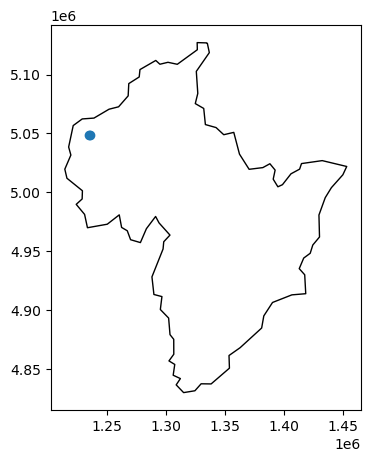

In [53]:
base = co.iloc[[1]].plot(color='none')
nz_height.iloc[1:3, :].plot(ax=base);

## 栅格数据的空间操作 {#spatial-ras}

### 空间子集化

上一章（@sec-manipulate-raster-objects 节）演示了如何检索与特定单元 ID 或行和列组合关联的值。 栅格对象还可以通过位置（坐标）和其他空间对象来提取。 要使用坐标进行子集化，我们可以使用“rasterio”文件连接对象的“.sample”方法，并结合坐标元组列表。 下面演示了这些方法，用于查找覆盖位于“elev”中坐标为 0.1、0.1 的点的单元格的值。 返回的对象是一个*生成器*：

In [54]:
src_elev.sample([(0.1, 0.1)])

<generator object sample_gen at 0x000001AA0BD6D890>

如果我们想要一次获得所有值，我们可以应用“list”。 结果是“16”：

In [55]:
list(src_elev.sample([(0.1, 0.1)]))

[array([16], dtype=uint8)]

栅格对象也可以是另一个栅格对象的子集，如下面的代码块所示：

...

In [56]:
# ...

空间子集的另一个常见用例是使用布尔掩码，基于具有相同范围和分辨率的另一个栅格或原始栅格，如图所示......为此，我们“擦除”数组中的值 一个栅格的，根据另一个相应的“掩模”栅格。 例如，让我们读取“elev.tif”栅格数组：

In [57]:
elev = src_elev.read(1)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

并创建相应的random mask：

In [58]:
np.random.seed(1)
mask = np.random.choice([True, False], elev.shape)
mask

array([[False, False,  True,  True, False, False],
       [False, False, False,  True,  True, False],
       [ True, False, False,  True,  True, False],
       [ True,  True,  True, False,  True,  True],
       [False,  True,  True,  True, False,  True],
       [ True,  True, False, False, False, False]])

在上面的代码块中，我们创建了一个名为“mask”的掩码对象，其值随机分配给“True”和“False”。 接下来，我们希望将“elev”的那些值为“False”的值保留在“mask”中（即，它们“不”被屏蔽）。 换句话说，我们想用“mask”屏蔽“elev”。 结果存储在名为“elev1”的副本中。 为了能够在栅格中存储“np.nan”，我们还需要将其转换为浮点型（请参阅@sec-summarizing-raster-objects）：

In [59]:
elev1 = elev.copy()
elev1 = elev1.astype('float64')
elev1[mask] = np.nan
elev1

array([[ 1.,  2., nan, nan,  5.,  6.],
       [ 7.,  8.,  9., nan, nan, 12.],
       [nan, 14., 15., nan, nan, 18.],
       [nan, nan, nan, 22., nan, nan],
       [25., nan, nan, nan, 29., nan],
       [nan, nan, 33., 34., 35., 36.]])

结果显示在@fig-raster-subset 中。

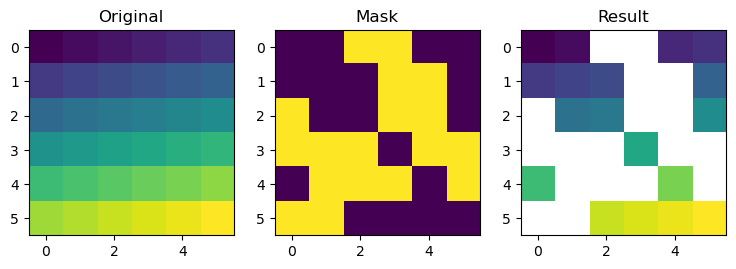

In [60]:
#| label: fig-raster-subset
#| fig-cap: Original raster (left). Raster mask (middle). Output of masking a raster (right).

fig, axes = plt.subplots(ncols=3, figsize=(9,5))
show(elev, ax=axes[0])
show(mask, ax=axes[1])
show(elev1, ax=axes[2])
axes[0].set_title("Original")
axes[1].set_title("Mask")
axes[2].set_title("Result");

上述方法也可用于用“nan”替换某些值（例如，预期错误的值）：

In [61]:
elev1 = elev.copy()
elev1 = elev1.astype('float64')
elev1[elev1 < 20] = np.nan
elev1

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, 20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29., 30.],
       [31., 32., 33., 34., 35., 36.]])

这些运算实际上是布尔本地运算，因为我们按像元比较两个栅格。 下一小节将更详细地探讨这些操作和相关操作。

### 地图代数 

“地图代数”这个术语是在 20 世纪 70 年代末创造的，用来描述用于分析地理栅格和（尽管不太突出）矢量数据的“一组约定、功能和技术”（Tomlin 1994）。 在这种情况下，我们将地图代数更狭义地定义为修改或汇总栅格像元值的运算，并参考周围像元、区域或适用于每个像元的统计函数。

地图代数运算往往很快，因为栅格数据集仅隐式存储坐标，因此有句老话“栅格更快，但矢量是校正器”。 栅格数据集中像元的位置可以通过使用其矩阵位置以及数据集的分辨率和原点（存储在标头中）来计算。 然而，对于处理来说，只要我们确保处理后单元格位置仍然相同，单元格的地理位置就几乎不相关。 此外，如果两个或多个栅格数据集共享相同的范围、投影和分辨率，则可以将它们视为矩阵进行处理。

这就是地图代数与 terra 包配合使用的方式。 首先，查询并检查栅格数据集的标头（如果地图代数运算适用于多个数据集），以确保数据集兼容。 其次，地图代数保留了所谓的一对一位置对应关系，这意味着细胞不能移动。 这与矩阵代数不同，在矩阵代数中，值会改变位置，例如在矩阵相乘或相除时。

地图代数（或使用栅格数据的制图建模）将栅格操作分为四个子类（Tomlin 1990），每个子类同时在一个或多个网格上工作：

* 本地或每单元操作
* 焦点或邻域操作。 大多数情况下，输出单元值是 3 x 3 输入单元块的结果
* 区域操作与焦点操作类似，但计算新值的周围像素网格可以具有不规则的大小和形状
* 全局或逐栅格操作； 这意味着输出像元可能从一个或多个完整栅格中获取其值

这种类型学根据每个像素处理步骤使用的单元数量和输出类型对地图代数运算进行分类。 为了完整起见，我们应该提到，栅格操作也可以按地形、水文分析或图像分类等学科进行分类。 以下部分参考工作示例解释了如何使用每种类型的地图代数运算。

### 本地操作 

局部操作包括一层或多层中的所有逐单元操作。
栅格代数是局部运算的经典用例 - 这包括从栅格中添加或减去值、对栅格进行平方和乘法。
栅格代数还允许逻辑运算，例如查找大于特定值（在下面的示例中为 5）的所有栅格单元。
使用“numpy”数组操作语法应用本地操作，如下所示：

首先，我们需要读取栅格值：

In [62]:
elev = src_elev.read(1)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

现在，可以应用任何按元素的数组运算。 例如：

In [63]:
elev + elev

array([[ 2,  4,  6,  8, 10, 12],
       [14, 16, 18, 20, 22, 24],
       [26, 28, 30, 32, 34, 36],
       [38, 40, 42, 44, 46, 48],
       [50, 52, 54, 56, 58, 60],
       [62, 64, 66, 68, 70, 72]], dtype=uint8)

@fig-raster-local-operations 演示了更多示例。

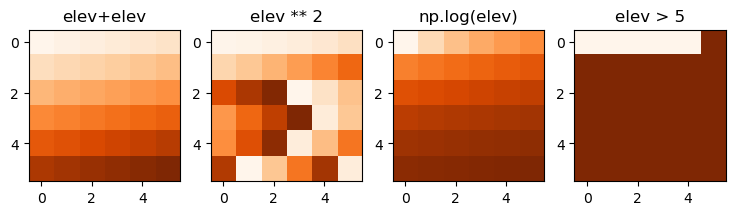

In [64]:
#| label: fig-raster-local-operations
#| fig-cap: 'Examples of different local operations of the elev raster object: adding two rasters, squaring, applying logarithmic transformation, and performing a logical operation.'

fig, axes = plt.subplots(ncols=4, figsize=(9,5))
show(elev + elev, ax=axes[0], cmap="Oranges")
show(elev ** 2, ax=axes[1], cmap="Oranges")
show(np.log(elev), ax=axes[2], cmap="Oranges")
show(elev > 5, ax=axes[3], cmap="Oranges")
axes[0].set_title("elev+elev")
axes[1].set_title("elev ** 2")
axes[2].set_title("np.log(elev)")
axes[3].set_title("elev > 5");

本地操作的另一个很好的例子是将数值区间分类为组，例如将数字高程模型分为低海拔（第 1 类）、中海拔（第 2 类）和高海拔（第 3 类）。 在这里，我们分配 0-12、12-24 和 24-36 范围内的栅格值，并分别重新分类为值 1、2 和 3。

In [65]:
recl = elev.copy()
recl[(elev > 0)  & (elev <= 12)] = 1
recl[(elev > 12) & (elev <= 24)] = 2
recl[(elev > 24) & (elev <= 36)] = 3

重新分类的结果显示在@fig-raster-reclassify中。

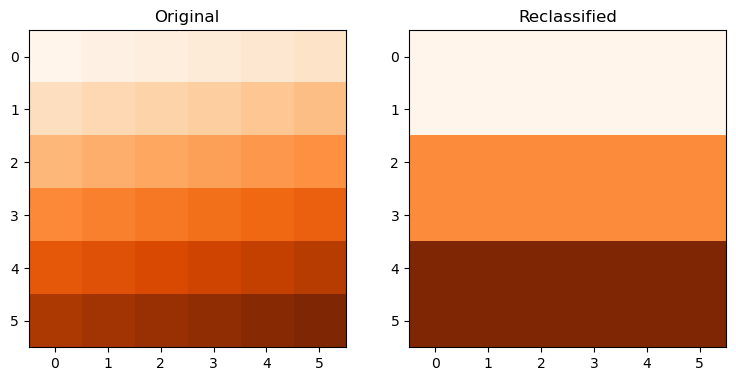

In [66]:
#| label: fig-raster-reclassify
#| fig-cap: Reclassifying a continuous raster into three categories.

fig, axes = plt.subplots(ncols=2, figsize=(9,5))
show(elev, ax=axes[0], cmap="Oranges")
show(recl, ax=axes[1], cmap="Oranges")
axes[0].set_title("Original")
axes[1].set_title("Reclassified");

归一化植被指数（NDVI）的计算是众所周知的局部（逐像素）栅格操作。 它返回一个值介于 -1 和 1 之间的栅格； 正值表示存在活植物（大多数> 0.2）。 NDVI 是根据遥感图像的红色和近红外 (NIR) 波段计算得出的，通常来自 Landsat 或 Sentinel 等卫星系统。 植被大量吸收可见光谱中的光，尤其是红色通道中的光，同时反射近红外光，解释了 NVDI 公式：

$$NDVI=\frac{NIR-Red} {NIR+Red}$$

让我们计算锡安国家公园多光谱卫星文件的 NDVI。

In [67]:
multi_rast = src_multi_rast.read()
nir = multi_rast[3,:,:]
red = multi_rast[2,:,:]
ndvi = (nir-red)/(nir+red)

将值 >1 转换为“无数据”：

In [68]:
ndvi[ndvi>1] = np.nan

当使用“show”函数绘制 RGB 图像时，该函数假设：

* 浮点数的值在“[0,1]”范围内，整数的值在“[0,255]”范围内（否则会被截断）
* 波段顺序为 RGB

为了“准备”用于“show”的多波段栅格，我们反转了波段的顺序（最初是 BGR+NIR），并除以最大值以将最大值设置为“1”：

In [69]:
multi_rast_rgb = multi_rast[(2,1,0), :, :] / multi_rast.max()

结果显示在@fig-raster-ndvi 中。

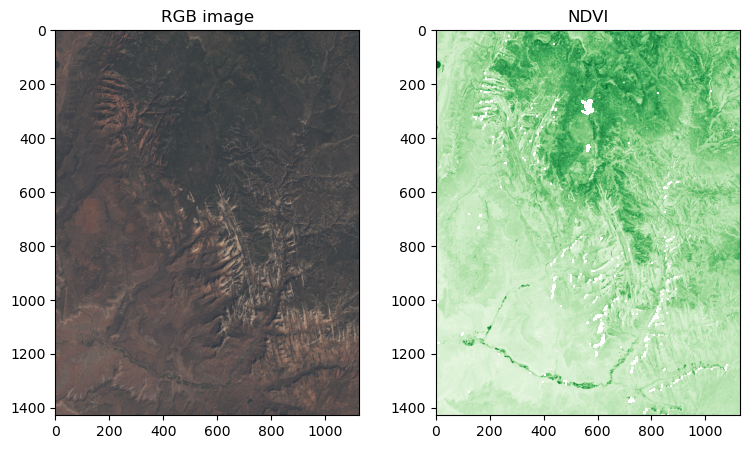

In [70]:
#| label: fig-raster-ndvi
#| fig-cap: RGB image (left) and NDVI values (right) calculated for the example satellite file of the Zion National Park.

fig, axes = plt.subplots(ncols=2, figsize=(9,5))
show(multi_rast_rgb, ax=axes[0], cmap="RdYlGn")
show(ndvi, ax=axes[1], cmap="Greens")
axes[0].set_title("RGB image")
axes[1].set_title("NDVI");

### 焦点操作

虽然局部函数在一个单元上运行，但可能来自多个层，但焦点操作会考虑中心（焦点）单元及其邻居。
所考虑的邻域（也称为内核、过滤器或移动窗口）通常大小为 3×3 个单元（即中心单元及其八个周围的邻居），但可以采用任何其他（不一定是矩形）形状，如 由用户定义。
焦点操作将聚合函数应用于指定邻域内的所有单元，使用相应的输出作为中心单元的新值，然后移动到下一个中心单元（图...）。
此操作的其他名称是空间过滤和卷积（Burrough、McDonnell 和 Lloyd 2015）。

在Python中，`scipy.ndimage`包有一个全面的[函数](https://docs.scipy.org/doc/scipy/reference/ndimage.html#filters)集合来执行`numpy`数组的过滤， 例如：

* `最小过滤器`
* `最大过滤器`
* `uniform_filter` （即均值过滤器）
* `中值过滤器`
ETC。

在这组函数中，我们使用以下之一定义移动窗口的形状：

* `size`——单个数字或元组，意味着这些维度的过滤器
* `footprint`——一个布尔数组，代表窗口形状和所包含元素的标识

除了特定的内置过滤器外，

* `convolve` 在乘以自定义的 `weights` 数组后应用求和函数
* `generic_filter` 可以传递任何自定义函数，用户可以在其中指定任何类型的基于窗口的自定义计算。

例如，这里我们在“elev”上应用窗口大小为“3”的最小过滤器：

In [71]:
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

In [72]:
elev_min = scipy.ndimage.minimum_filter(elev, size=3)
elev_min

array([[ 1,  1,  2,  3,  4,  5],
       [ 1,  1,  2,  3,  4,  5],
       [ 7,  7,  8,  9, 10, 11],
       [13, 13, 14, 15, 16, 17],
       [19, 19, 20, 21, 22, 23],
       [25, 25, 26, 27, 28, 29]], dtype=uint8)

应特别注意边缘像素。 应该如何计算？ `scipy.ndimage` 通过 `mode` 参数提供了几个选项：

* `reflect`（默认）
* `常数`
* `最近的`
*`镜子`
* `包裹`

有时人为地延伸光栅边缘被认为是不合适的。
换句话说，我们可能希望生成的栅格仅包含具有“完整”窗口的像素值，例如具有统一的样本大小或因为所有方向上的值都很重要（例如在地形计算中）。
在`scipy.ndimage`中没有特定的选项*不*来扩展边缘。
但是，为了获得相同的效果，可以根据过滤器大小在多个行和列中为过滤后的数组的边缘分配“nan”。
例如，当使用“size=3”的过滤器时，像素的第一“层”可能会被分配为“nan”，反映这些像素具有不完整的 3*3 邻域的事实：

In [73]:
elev_min = elev_min.astype('float')
elev_min[:, [0, -1]] = np.nan
elev_min[[0, -1], :] = np.nan
elev_min

array([[nan, nan, nan, nan, nan, nan],
       [nan,  1.,  2.,  3.,  4., nan],
       [nan,  7.,  8.,  9., 10., nan],
       [nan, 13., 14., 15., 16., nan],
       [nan, 19., 20., 21., 22., nan],
       [nan, nan, nan, nan, nan, nan]])

我们可以快速检查输出是否符合我们的预期。
在我们的示例中，最小值必须始终是移动窗口的左上角（请记住，我们是通过从左上角开始按行将像元值递增 1 创建输入栅格的）。

焦点函数或滤波器在图像处理中起着主导作用。 低通或平滑滤波器使用均值函数来消除极值。
对于分类数据，我们可以用众数替换均值，众数是最常见的值。
相比之下，高通滤波器强调特征。 此处以线检测拉普拉斯滤波器和索贝尔滤波器为例。

地形处理，即坡度、坡向和流向等地形特征的计算，依赖于焦点函数。
`richdem` 包中的 `TerrainAttribute` 函数可用于计算常见的[指标](https://richdem.readthedocs.io/en/latest/python_api.html?highlight=TerrainAttribute#richdem.TerrainAttribute)，通过 `attrib` 参数，即：

* `slope_riserun` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_percentage` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_degrees` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `slope_radians` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `aspect` 	Horn (1981) doi: 10.1109/PROC.1981.11918
* `curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107
* `planform_curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107
* `profile_curvature` 	Zevenbergen and Thorne (1987) doi: 10.1002/esp.3290120107

### Zonal operations

就像焦点操作一样，区域操作将聚合函数应用于多个栅格单元。
然而，第二个栅格通常具有分类值，在区域操作的情况下定义区域过滤器（或“区域”），这与上一节中介绍的焦点操作情况下的预定义邻域窗口相反。
因此，定义区域过滤器的栅格单元不一定必须是邻居。
我们的粒度栅格就是一个很好的例子，如图 3.2 的右图所示：不同的粒度在整个栅格中不规则地分布。
最后，区域操作的结果是按区域分组的汇总表，这就是为什么该操作在 GIS 领域也称为区域统计。 这与返回光栅对象的焦点操作形成对比。

为了进行演示，让我们回到“grain”和“elev”栅格（图 3.2）。 为了计算区域统计数据，我们使用具有栅格值的数组。 `elev` 数组之前已经导入：

In [74]:
grain = src_grain.read(1)
grain

array([[1, 0, 1, 2, 2, 2],
       [0, 2, 0, 0, 2, 1],
       [0, 2, 2, 0, 0, 2],
       [0, 0, 1, 1, 1, 1],
       [1, 1, 1, 2, 1, 1],
       [2, 1, 2, 2, 0, 2]], dtype=uint8)

我们的目的是计算由 *grain* 值定义的每个区域中 *elevation* 的平均值（或任何其他汇总函数）。 首先，我们可以使用“np.unique”获取定义区域的唯一值：

In [75]:
np.unique(grain)

array([0, 1, 2], dtype=uint8)

现在，我们可以使用[dictionary conprehension](https://stackoverflow.com/questions/14507591/python-dictionary-compressive)将“elev”数组“拆分”为单独的一维数组，每个“grain”组都有值 ，键是唯一的“grain”值：

In [76]:
z = {i: elev[grain == i] for i in np.unique(grain)}
z

{0: array([ 2,  7,  9, 10, 13, 16, 17, 19, 20, 35], dtype=uint8),
 1: array([ 1,  3, 12, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32], dtype=uint8),
 2: array([ 4,  5,  6,  8, 11, 14, 15, 18, 28, 31, 33, 34, 36], dtype=uint8)}

在此阶段，我们可以扩展字典理解表达式来计算与每个粒度类别相关的平均海拔。 我们不是将高程值 (`elev[grain==i]`) 放入字典值中，而是将它们的平均值 (`elev[grain==i].mean()`) 放入：

In [77]:
z = {i: elev[grain == i].mean() for i in np.unique(grain)}
z

{0: 14.8, 1: 21.153846153846153, 2: 18.692307692307693}

这将返回每个类别的统计数据，这里是每个粒度类别的平均海拔。 例如，以粒度“0”为特征的像素的平均高程为“14.8”，依此类推。


### 合并栅格

假设我们想要计算 NDVI（请参阅@sec-raster-local-operations），并且还想要根据研究区域内观测的高程数据计算地形属性。
此类计算依赖于遥感信息。
相应的图像通常被划分为覆盖特定空间范围的场景（即“图块”），并且通常一个研究区域覆盖多个场景。
然后，我们需要合并（也称为“马赛克”）我们研究区域覆盖的场景。
在最简单的情况下，我们可以合并这些场景，即将它们并排放置。
然而，无论场景数量多少，步骤都是相同的。
如果所有场景都“对齐”（即共享相同的原点和分辨率），则可以将其视为简单地将它们粘合到一个大光栅中； 否则，所有场景都将重新采样（请参阅@sec-raster-resampling）到第一个场景定义的网格。

例如，让我们合并来自奥地利 (`aut.tif`) 和瑞士 (`ch.tif`) 两个 SRTM 高程图块的数字高程数据。
可以使用函数“rasterio.merge.merge”完成合并，该函数接受光栅文件连接的“列表”，并返回新的“ndarray”和“转换”：




In [78]:
src_1 = rasterio.open('data/aut.tif')
src_2 = rasterio.open('data/ch.tif')
out_image, out_transform = rasterio.merge.merge([src_1, src_2])

输入和结果都显示在 @fig-raster-merge 中：

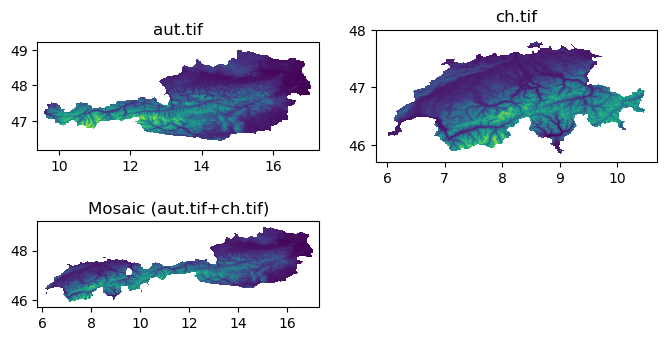

In [79]:
#| label: fig-raster-merge
#| fig-cap: Raster merging

fig, axes = plt.subplots(2, 2, figsize=(8,4))
show(src_1, ax=axes[0][0])
show(src_2, ax=axes[0][1])
show(out_image, transform=out_transform, ax=axes[1][0])
axes[1][1].axis('off')
axes[0][0].set_title('aut.tif')
axes[0][1].set_title('ch.tif')
axes[1][0].set_title('Mosaic (aut.tif+ch.tif)');

默认情况下（`method='first'`），重叠区域保留*first* 栅格的值。 其他可能的方法有：

* `'last'`---最后一个栅格的值
* `'min'`---最小值
* `'max'`---最大值

当处理非重叠图块时，例如“aut.tif”和“ch.tif”（上面），“method”参数没有实际效果。 然而，当我们想要组合不同日期拍摄的场景的光谱图像时，它就变得相关了。 上述四个“方法”选项并没有涵盖我们想要计算平均值时通常需要的场景，例如从一组部分重叠的卫星图像（例如 Landsat）计算季节性平均 NDVI 图像。 用于计算马赛克以及“平均”任何重叠的“rasterio.merge.merge”的替代工作流程可能需要执行两个步骤：

* 将所有场景重新采样到一个通用的“全局”网格中（@sec-raster-resampling），从而生成一系列“匹配”栅格（每个场景周围的区域设置为“无数据”）
* 通过栅格代数 (@sec-raster-local-operations) 对栅格进行平均，如 `np.mean(m,axis=0)` 或 `np.nanmean(m,axis=0)`，其中 `m` 是多波段数组，它将返回单波段平均值数组